---
title: "Week 3: K-means"
---

Colab Link: [Click here!](https://drive.google.com/file/d/1uA_HU11baHjC-I1RIUA5qw92l55Z0ea6/view?usp=sharing){target="_blank"}

# Construction of a dataset with implicit clustering

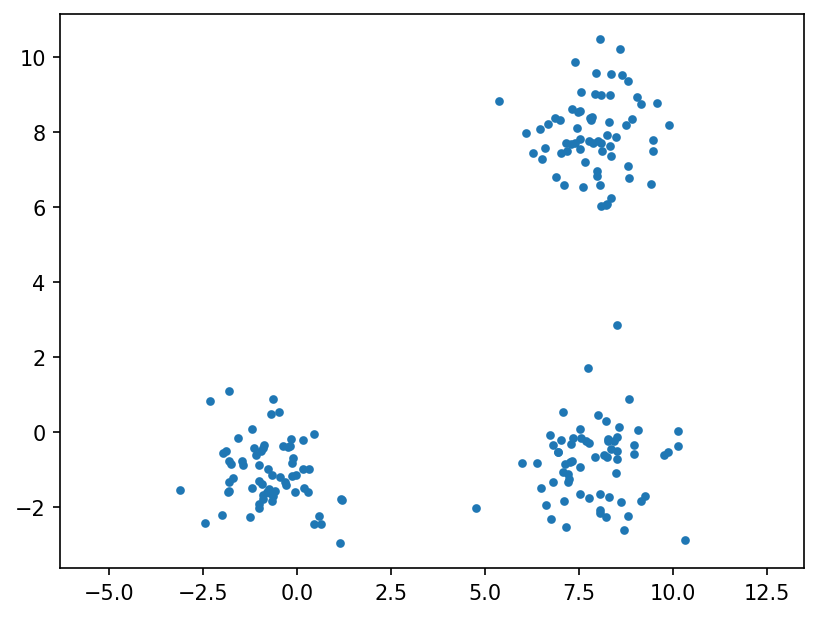

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.dpi'] = 150

N = 200
np.random.seed(42)

c1 = np.random.randn(N//3, 2) + np.array([8, 8])
c2 = np.random.randn(N//3, 2) + np.array([8, -1])
c3 = np.random.randn(N//3, 2) + np.array([-1, -1])

X = np.concatenate((c1, c2, c3))
plt.scatter(X[:, 0], X[:, 1], s=10);
plt.axis('equal')
plt.show()

# Is PCA Enough?

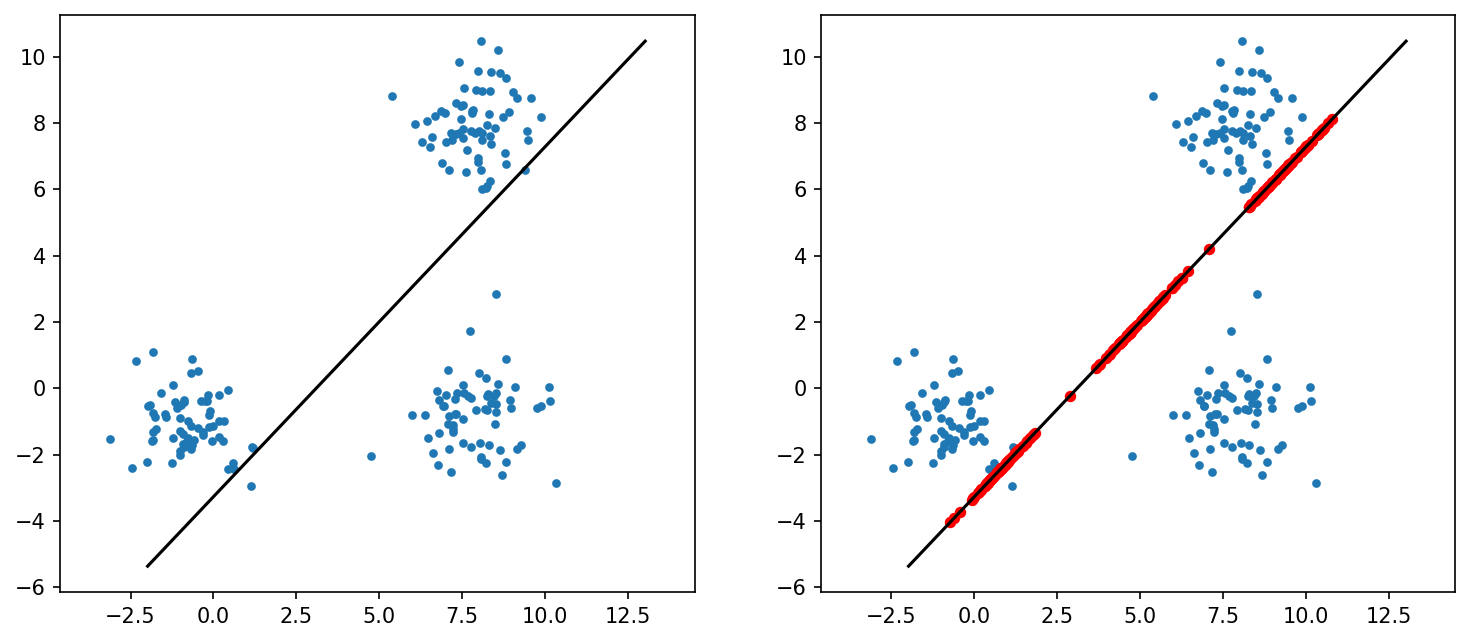

In [ ]:
# Perform PCA on X

plt.figure(figsize=(12, 5))

X_mean = X.mean(axis=0)

X_centered = X - X_mean
cov_X = np.cov(X_centered.T)
eig_val, eig_vec = np.linalg.eigh(cov_X)
pc_vec = eig_vec[:,-1] / eig_vec[:,-1][0]
x_range = np.array([-7, 8])

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], s=10);
plt.axis('equal')
plt.plot(x_range + X_mean[0], x_range * pc_vec[1] + X_mean[1], color='black')

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], s=10);
X_proj = np.array([i * eig_vec[:, -1] + X_mean for i in X_centered @ eig_vec[:, -1]])
plt.scatter(X_proj[:, 0], X_proj[:, 1], s=20, color='red');
plt.axis('equal')
plt.plot(x_range + X_mean[0], x_range * pc_vec[1] + X_mean[1], color='black')

plt.show()

We notice the dataset generated above has some implicit "clustering". When we run PCA however, no information about this phenomenon is captured in the representations generated by it. Hence, a different problem formulation is required, which is able to capture this similarity in datasets that we postulate to follow this pattern.

# K-means Clustering - Lloyd's Algorithm
- It is an unsupervised learning algorithm
- The algorithm tries to capture "similarity" between datapoints, and assign a cluster indicator for each clique.

## Problem Definition

In this context, the objective becomes the following:

$$
\underset{z \in S}{\text{min }} \sum_{i=1}^{n}||x_i - μ_{z_i}||^2_2
$$

Where:
- $x_i$ denotes the i'th datapoint
- $z_i$ denotes the cluster indicator of $x_i$
- $μ_{z_i}$ denotes the mean of the cluster with indicator $z_i$
- $S$ denotes the set of all possible cluster assignments. Note that S is **finite**

In [ ]:
def obj(X, cluster_centers):
  return sum([np.min([np.linalg.norm(x_i - cluster_center)**2 for cluster_center in cluster_centers]) for x_i in X])

## Algorithm Strategy
1. **Initialization Step** : Assign *random* datapoints from the dataset as the cluster centers
2. **Cluster Assignment Step** : For every datapoint $x_i$, assign a cluster indicator $z_i = \underset{j \in [1, 2, ..., n]}{\text{min }} ||x_i - μ_j||^2_2$
3. **Recompute cluster centers** : For every cluster indicator $j \in [1, 2, ..., n]$ recompute
$$μ_j = \frac{\sum_{i=1}^{n}x_i \cdot \mathbf{1}(z_i=j)}{\sum_{i=1}^{n} \mathbf{1}(z_i=j)}$$
4. Repeat steps 2 and 3 until *convergence*.

**Convergence** in accordance to the objective is established, since the following can be shown:
- The set of all possible cluster assignments $S$ is **finite**.
- The objective function value strictly decreases after every iteration of Lloyd's.

The initialization for K-Means can be done in *smarter* ways than a random initialization - which improve the chance of lloyd's converging to a good cluster assignment; with a lesser number of iterations.

It is important to note that the final assignment need not necessarily be the best answer (global optima) to the objective function, but it is good enough in practice.


## Initialization Step
n points from the dataset are randomly chosen as cluster centers, where n is the number of clusters - a hyperparameter

In [ ]:
n = 3
# cluster_centers = X[np.random.choice(len(X), 3)]
cluster_centers = X[[70, 85, 80]]

## Cluster Assignment Step
For every datapoint, the cluster indicator whose center is closest to the datapoint is assigned as its cluster.

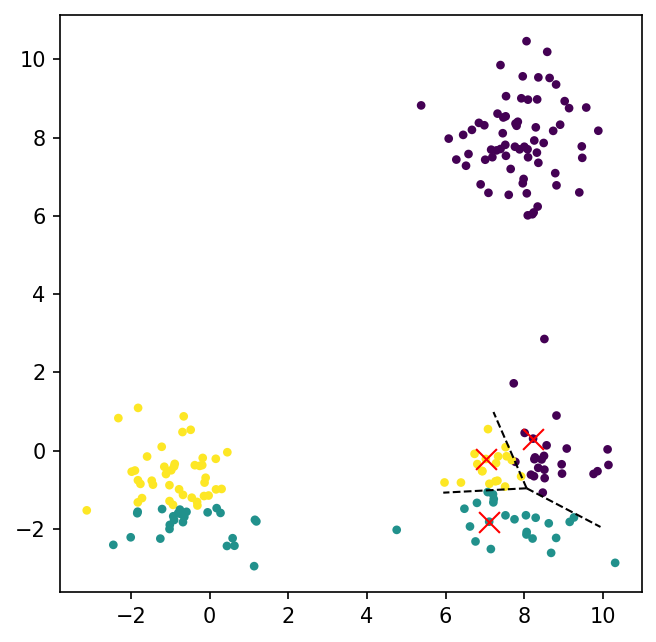

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def cluster_assignment(X, cluster_centers):
  z = np.zeros(X.shape[0])
  for i in range(X.shape[0]):
    z[i] = np.argmin([np.linalg.norm(X[i] - cluster_center) for cluster_center in cluster_centers])
  return z

z = cluster_assignment(X, cluster_centers)

fig, (ax) = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

ax.scatter(X[:, 0], X[:, 1], c=z, s=10);
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker = 'x', s = 100, color = 'red', linewidth=1)

vor = Voronoi(cluster_centers)
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False);

ax.axis('equal');

For every cluster, there is a corresponding interesction of half-spaces - called Voronoi regions. The K-Means algorithm, equivalently, is trying to find the most optimal Voronoi partition of the space, that minimizes the objective function.

## Recompute Means/Cluster Centers
For every cluster, the cluster center is updated to the mean of the points in the cluster.

In [ ]:
def recompute_clusters(X, z):
  cluster_centers = np.array([np.mean(X[z == i], axis = 0) for i in range(n)])
  return cluster_centers

# Iteration of K-means
- Assign clusters based on new cluster centers.
- Recompute cluster centers based on new clusters.

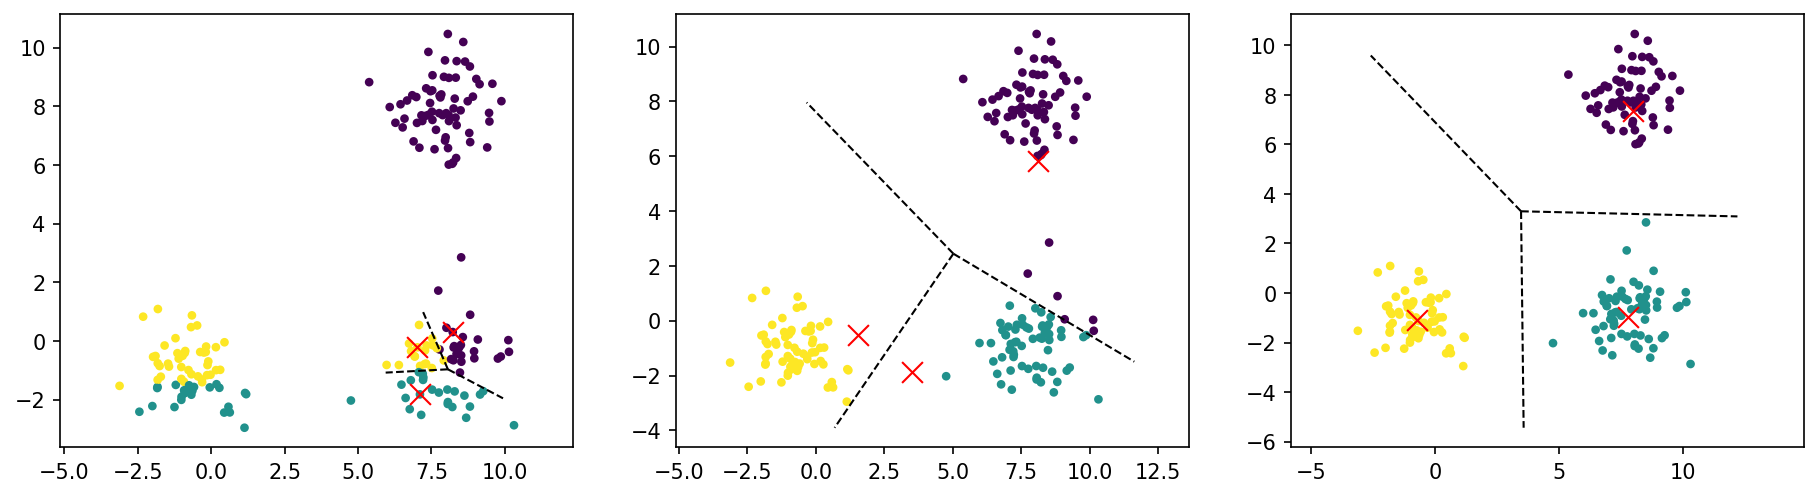

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 3.75)

for i in range(3):

  z = cluster_assignment(X, cluster_centers) # cluster_centers -> NEW cluster assignment ->

  ax[i].scatter(X[:, 0], X[:, 1], c=z, s=10);
  ax[i].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker = 'x', s = 100, color = 'red', linewidth=1)
  vor = Voronoi(cluster_centers)
  voronoi_plot_2d(vor, ax=ax[i], show_points=False, show_vertices=False)
  ax[i].axis('equal');

  cluster_centers = recompute_clusters(X, z) # -> cluster assignment -> NEW cluster centers


## Generate a complex dataset with 6 clusters
We make use of the convienient make_blobs data generator from the scikit-learn ibrary.

(-5.0, 5.0, -4.0, 5.0)

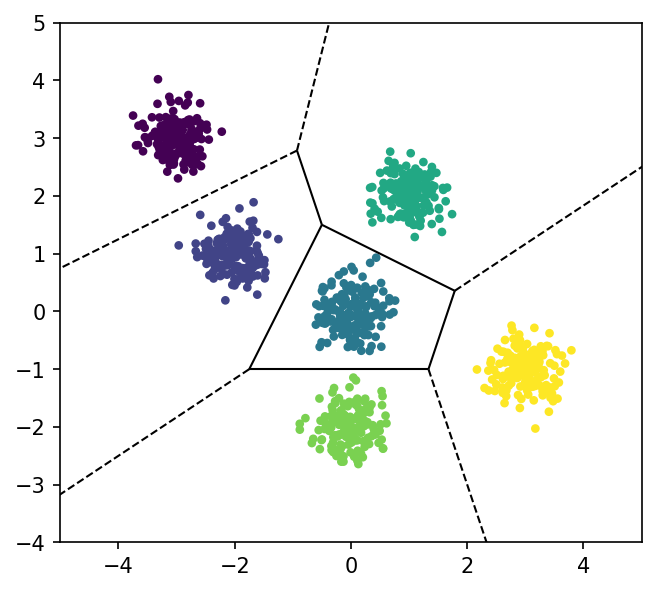

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

cen = [(-3, 3), (-2, 1), (0, 0), (1, 2), (0, -2), (3, -1)]
X, ideal_z = make_blobs(n_samples=1000, centers=cen, n_features=2, cluster_std=0.3, random_state=13, center_box=(-3, 3))

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=10, c=ideal_z)
vor = Voronoi(cen)
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False);
fig.set_size_inches(5, 4.5)
ax.axis([-5, 5, -4, 5])

In [ ]:
# the make_blobs generator returns the optimal/good cluster assignment along with the dataset
# this function checks whether the result from lloyd's is equivalent to the optimal assignment

def ideal_check(ideal, obtained):
  mapping = dict([(i, -1) for i in range(n)])

  for i in range(len(ideal)):
    if mapping[ideal[i]] == -1:
      mapping[ideal[i]] = obtained[i]
    elif mapping[ideal[i]] != obtained[i]:
      return False

  return True

## Lloyd's Algorithm Definition





In [ ]:
from IPython.display import HTML
from matplotlib import animation

def lloyds(cluster_centers, X, z, artists = [], animate=True, fig=None, ax=None, ax1=None, n_iter=0, n = len(cen)):
  loss = []
  if fig is None and animate:
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4.15))
    title = ax.set_title('')
    artists = []

  if animate:
      frame = []
      frame.append(ax.scatter(X[:, 0], X[:, 1], c=z, s=10))
      frame.append(ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker = 'x', s = 100, color = 'red', linewidth=1))
      frame.append(ax.text(0.5, 1.05, f'Iteration {n_iter} | Cluster Assignment', transform=ax.transAxes, ha="center"))

      vor = Voronoi(cluster_centers)
      d = voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False);
      frame += list(d.axes[0].lines[-1:] + d.axes[0].collections[-2:])
      ax.axis([-5, 5, -4, 5])

      loss.append(obj(X, cluster_centers))
      m = 1
      frame.append(ax1.scatter([0], [loss[0]], color='red', marker='x', s=30))
      frame.append(ax1.text(0.5, 1.05, 'Objective Function', transform=ax1.transAxes, ha="center"))
      frame.append(ax1.text(0.5, -0.1, 'Iterations', transform=ax1.transAxes, ha="center"))

      artists.append(frame)

  converged = False
  while not converged:

    # cluster_centers = recompute_clusters(X, z)
    for i in range(n):
      cluster_points = X[z==i]
      if len(cluster_points)>0:
        cluster_centers[i] = np.mean(cluster_points, axis=0)

    n_iter += 1

    # Modified cluster assignment step
    converged = True

    if animate:
      frame = []
      frame.append(ax.scatter(X[:, 0], X[:, 1], c=z, s=10))
      frame.append(ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker = 'x', s = 100, color = 'red', linewidth=1))
      frame.append(ax.text(0.5, 1.05, f'Iteration {n_iter} | Cluster Recomputation', transform=ax.transAxes, ha="center"))

      vor = Voronoi(cluster_centers)
      d = voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False);
      frame += list(d.axes[0].lines[-1:] + d.axes[0].collections[-2:])
      ax.axis([-5, 5, -4, 5])

      for i in range(0, len(loss)-1, 2):
        frame.append(list(ax1.plot([i/2, (i+2)/2], [loss[i], loss[i+1]], color='red', marker='x', markersize=5))[0])

      loss.append(obj(X, cluster_centers))
      frame.append(list(ax1.plot([(len(loss)-2)/2, (len(loss)-1)/2], [loss[-2], loss[-1]], color='red', linestyle=':'))[0])
      # lines = list(ax1.plot(np.arange(len(loss))/2, loss, color='red', marker='xo', markersize=6))
      # frame += lines
      frame.append(ax1.text(0.5, 1.05, 'Objective Function', transform=ax1.transAxes, ha="center"))
      frame.append(ax1.text(0.5, -0.1, 'Iterations', transform=ax1.transAxes, ha="center"))

      artists.append(frame)

    for i in range(len(X)):
      z_i = np.argmin([np.linalg.norm(X[i] - cluster_center) for cluster_center in cluster_centers])

      if z_i != z[i]:
        z[i] = z_i
        converged = False

    if animate and not converged:
      frame = []
      frame.append(ax.scatter(X[:, 0], X[:, 1], c=z, s=10))
      frame.append(ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker = 'x', s = 100, color = 'red', linewidth=1))
      frame.append(ax.text(0.5, 1.05, f'Iteration {n_iter} | Cluster Re-assignment', transform=ax.transAxes, ha="center"))

      vor = Voronoi(cluster_centers)
      d = voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False);
      frame += list(d.axes[0].lines[-1:] + d.axes[0].collections[-2:])
      ax.axis([-5, 5, -4, 5])

      loss.append(obj(X, cluster_centers))
      m = 1
      for i in range(0, len(loss)-1, 2):
        frame.append(list(ax1.plot([i/2, (i+2)/2], [loss[i], loss[i+1]], color='red', marker='x', markersize=5))[0])

      frame.append(ax1.text(0.5, 1.05, 'Objective Function', transform=ax1.transAxes, ha="center"))
      frame.append(ax1.text(0.5, -0.1, 'Iterations', transform=ax1.transAxes, ha="center"))

      artists.append(frame)

  if animate:
    plt.close()
    return fig, (ax, ax1), cluster_centers, artists
  else:
    return cluster_centers, n_iter

## Random Initialization
We now run Lloyd's algorithm on the dataset with random initialization. We use the ```ideal_check``` function to see whether the obtained cluster from lloyd's is optimal; else we re-run it again.

An animation using Matplotlib's ```ArtistAnimation``` is shown to illustrate the working of this strategy.

In [ ]:
cluster_centers = X[np.random.choice(len(X), n)]
z = cluster_assignment(X, cluster_centers)

fig, ax, final_clusters, artists = lloyds(cluster_centers, X, z)

while not ideal_check(cluster_assignment(X, final_clusters), ideal_z):

  cluster_centers = X[np.random.choice(len(X), n)]
  z = cluster_assignment(X, cluster_centers)
  fig, ax, final_clusters, artists = lloyds(cluster_centers, X, z)

anim = animation.ArtistAnimation(fig, artists, interval=500, repeat=False, blit=False);
HTML(anim.to_jshtml())

Some initializations do not give a good clustering

In [ ]:
cluster_centers = X[np.random.choice(len(X), n)]
z = cluster_assignment(X, cluster_centers)
fig, ax, final_clusters, artists = lloyds(cluster_centers, X, z)

while ideal_check(cluster_assignment(X, final_clusters), ideal_z):
  cluster_centers = X[np.random.choice(len(X), n)]
  z = cluster_assignment(X, cluster_centers)
  fig, ax, final_clusters, artists = lloyds(cluster_centers, X, z)

anim = animation.ArtistAnimation(fig, artists, interval=500, repeat=False, blit=False);
HTML(anim.to_jshtml())

# Smart Initialization | k-means++

k-means++ is an intitialization step which tries to improve the chance for Lloyd's algorithm to converge to a good clustering.

The exact algorithm is as follows:

- Choose one center uniformly at random among the data points.
- For each data point x not chosen yet, compute $D(x)^2$, the squared distance between x and the nearest center that has **already been chosen**.
- Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to $D(x)^2$.
- Repeat Steps 2 and 3 until k centers have been chosen.

After choosing k cluster centers, we proceed as usual with Lloyd's algorithm.

The intuition behind this approach is that spreading out the k initial cluster centers is a good thing: the first cluster center is chosen uniformly at random from the data points that are being clustered, after which each subsequent cluster center is chosen from the remaining data points with probability proportional to its squared distance from the point's closest existing cluster center.

In [ ]:
def plusplus(animate=True, n = len(cen)):
  initial_clusters = np.array(X[np.random.choice(len(X), 1)])

  if animate:
      artists = []
      fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4.15), dpi=150)

      a = ax.scatter(X[:, 0], X[:, 1], color="pink", s=10);
      b = ax.scatter(initial_clusters[:, 0], initial_clusters[:, 1], marker = 'x', s = 200, color = 'red', linewidth=1);
      c = ax.text(0.5, 1.05, f'K-Means ++', transform=ax.transAxes, ha="center")

      artists.append([a, c])

      c = ax.text(0.5, 1.05, f'K-Means ++ | Initialization 1', transform=ax.transAxes, ha="center")
      artists.append([a, b, c])

  for i in range(1, n):
    # Rescore based on selected clusters
    scores = np.array([min([np.linalg.norm(datapoint-cluster)**2 for cluster in initial_clusters]) for datapoint in X])

    # Normalize scores to probability
    probabilities = scores/scores.sum()

    initial_clusters = np.append(initial_clusters, X[np.random.choice(len(X), 1, p=probabilities)], axis=0)
    if animate:
      a = ax.scatter(X[:, 0], X[:, 1], color="pink", s=10);
      b = ax.scatter(initial_clusters[:, 0], initial_clusters[:, 1], marker = 'x', s = 200, color = 'red', linewidth=1);
      c = ax.text(0.5, 1.05, f'K-Means ++ | Initialization {i+1}', transform=ax.transAxes, ha="center")

      artists.append([a, b, c])

  if animate:
    return fig, (ax, ax1), initial_clusters, artists

  return initial_clusters

We now run Lloyd's with K-means++ initialization strategy. The ```plusplus``` function does this smart intialization for us; and is configured to plot frames for each point's initialization, which we use to visualize in our animation.

In [ ]:
# cluster_centers = X[np.random.choice(len(X), n)]
fig, (ax, ax1), cluster_centers, artists = plusplus()
z = cluster_assignment(X, cluster_centers)
fig, (ax, ax1), final_clusters, artists = lloyds(cluster_centers, X, z, artists=artists, fig=fig, ax=ax, ax1=ax1)

while not ideal_check(cluster_assignment(X, final_clusters), ideal_z):
  fig, ax, cluster_centers, artists = plusplus()
  z = cluster_assignment(X, cluster_centers)
  fig, (ax, ax1), final_clusters, artists = lloyds(cluster_centers, X, z, artists=artists, fig=fig, ax=ax, ax1=ax1)

anim = animation.ArtistAnimation(fig, artists, interval=500, repeat=False, blit=False);
HTML(anim.to_jshtml())

### Choice of K - Elbow Method

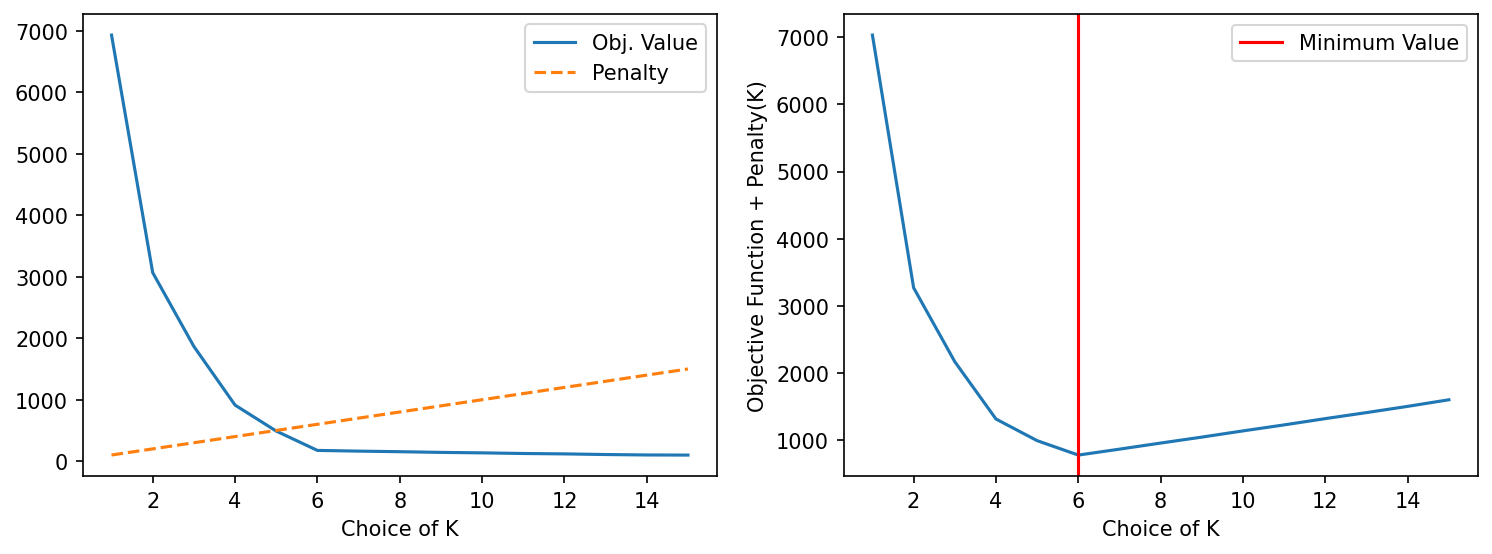

In [ ]:
K = list(range(1, 16))
obj_vals = []
for k in K:
  obj_vals_k = []
  for _ in range(3):
    cluster_centers = plusplus(animate=False, n=k)
    cluster_centers, n_iter = lloyds(cluster_centers, X, cluster_assignment(X, cluster_centers), animate=False, n=k)
    obj_vals_k.append(obj(X, cluster_centers))
  obj_vals.append(min(obj_vals_k))

penalties = [100*i for i in K]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(K, obj_vals, label='Obj. Value')
plt.plot(K, penalties, linestyle='--', label='Penalty')
plt.xlabel('Choice of K')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(K, [penalties[i] + obj_vals[i] for i in range(15)])
plt.xlabel('Choice of K')
plt.ylabel('Objective Function + Penalty(K)');
plt.axvline(x=min(zip(K, [penalties[i] + obj_vals[i] for i in range(15)]), key=lambda i: i[1])[0], color='red', label='Minimum Value')
plt.legend()

# Comparison of Initialization Strategies - Random vs. K-Means++

For each initialization strategy, we conduct 1000 experiments and record the following:

- Number of Iterations to converge
- SSE (objective value) for final cluster centers
- Number of convergences that are "ideal" (global optimum)
- Time taken from intialization to convergence

## Experiments

### Random Initialization

In [ ]:
from timeit import default_timer as timer

noof_trials = 1000

random = {'ideals' : 0,
          'SSE' : [],
          'iters' : [],
          'time' : []}

exp_start = timer()
for _ in range(noof_trials):

  start = timer()
  cluster_centers = X[np.random.choice(len(X), n)]
  final_clusters, n_iter = lloyds(cluster_centers, X, cluster_assignment(X, cluster_centers), animate=False)

  random['time'].append(timer()-start)
  random['ideals'] += int(ideal_check(ideal_z, cluster_assignment(X, final_clusters)))
  random['SSE'].append(obj(X, final_clusters))
  random['iters'].append(n_iter)

print(f'Experiment done in {timer()-exp_start:.2f} seconds')

Experiment done in 670.24 seconds


### K-Means++ Initialization

In [ ]:
kmplusplus = {'ideals' : 0,
              'SSE' : [],
              'iters' : [],
              'time' : []}

exp_start = timer()
for _ in range(noof_trials):

  start = timer()
  cluster_centers = plusplus(animate=False)
  final_clusters, n_iter = lloyds(cluster_centers, X, cluster_assignment(X, cluster_centers), animate=False)

  kmplusplus['time'].append(timer()-start)
  kmplusplus['ideals'] += int(ideal_check(ideal_z, cluster_assignment(X, final_clusters)))
  kmplusplus['SSE'].append(obj(X, final_clusters))
  kmplusplus['iters'].append(n_iter)

print(f'Experiment done in {timer()-exp_start:.2f} seconds')

Experiment done in 539.66 seconds


## Results

### SSE Comparison

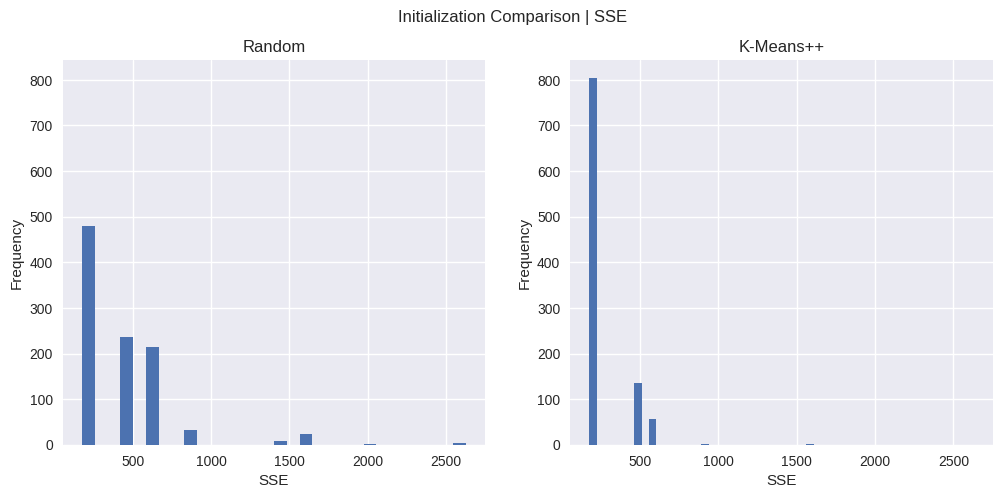

In [ ]:
plt.style.use('seaborn-v0_8')

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Initialization Comparison | SSE')

ax1 = plt.subplot(121)
ax1.hist(random['SSE'], bins=30)
ax1.set_title('Random')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('SSE')

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
ax2.hist(kmplusplus['SSE'], bins=30)
ax2.set_title('K-Means++')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('SSE')

plt.show()

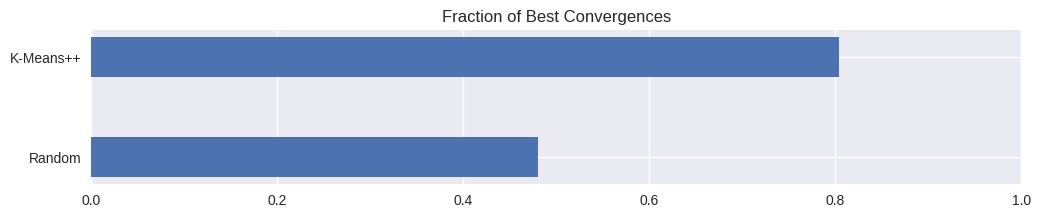

In [ ]:
plt.figure(figsize=(12, 2))
plt.title('Fraction of Best Convergences')
plt.barh(['Random', 'K-Means++'], [random['ideals']/noof_trials, kmplusplus['ideals']/noof_trials], height=0.4);
plt.xlim([0, 1]);

The SSE for the optimal cluster assignment for this particular dataset is around 175. We observe from the above charts that K-Means++ does indeed have a higher chance (0.8) of converging to this as compared to Vanilla K-Means (0.5).

### Number of Iterations Comparison

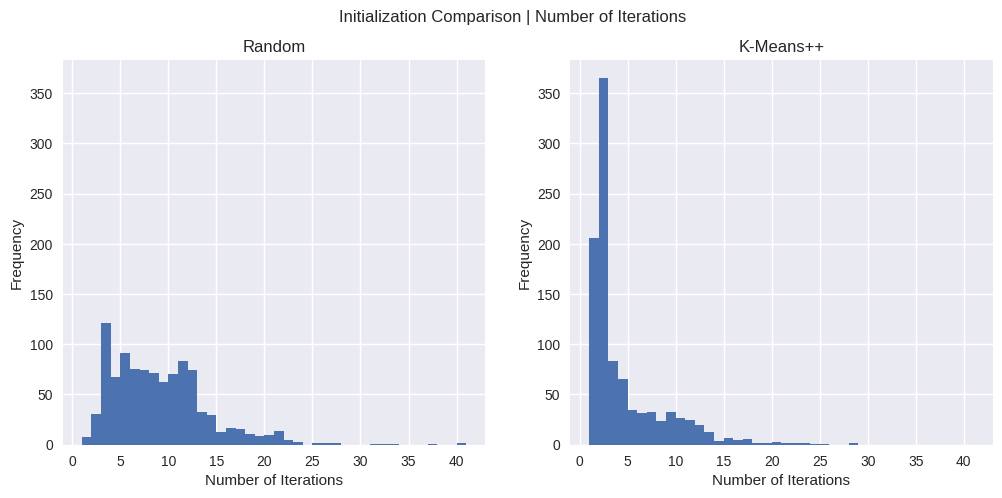

In [ ]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Initialization Comparison | Number of Iterations')

ax1 = plt.subplot(121)
ax1.hist(random['iters'], bins=max(random['iters'])-min(random['iters']))
ax1.set_title('Random')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Number of Iterations')

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
ax2.hist(kmplusplus['iters'], bins=max(kmplusplus['iters'])-min(kmplusplus['iters']))
ax2.set_title('K-Means++')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Number of Iterations')

plt.show()

For Vanilla K-Means, we observe that the number of iterations has quite a bit of variation, with an average of 8.75 iterations to convergence.

K-Means++ has a relatively smaller spread, with an average of 4.2 iterations to convergence (post intialization).

### Time Taken Comparison

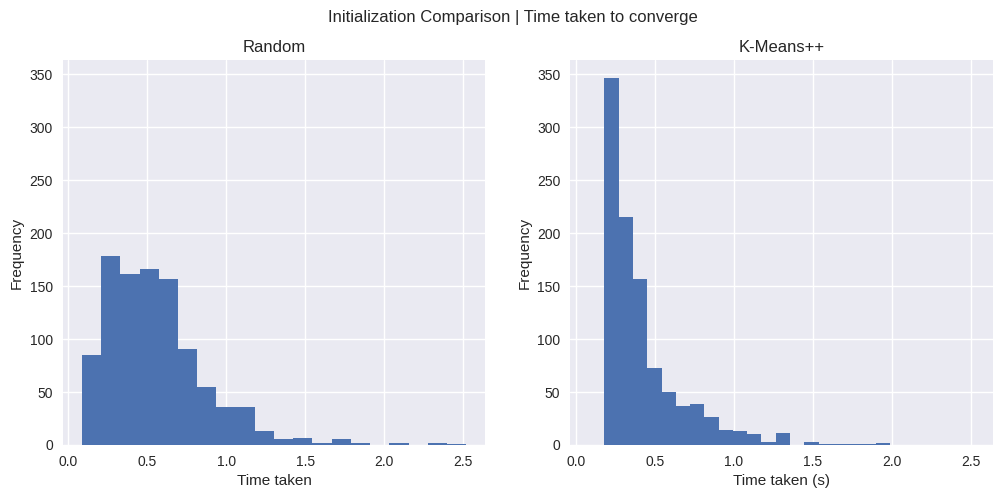

In [ ]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Initialization Comparison | Time taken to converge')

ax1 = plt.subplot(121)
ax1.hist(random['time'], bins=20)
ax1.set_title('Random')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Time taken')

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
ax2.hist(kmplusplus['time'], bins=20)
ax2.set_title('K-Means++')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Time taken (s)')

plt.show()

In [ ]:
np.array(kmplusplus['time']).mean()

0.4248704458820016

Similar to the results for number of iterations, the time taken till convergence also has a wide spread for Random Initialization, with an average of 0.55s. K-Means++ has an average of 0.42s.

# Worked-out Examples



## K-Means
K-Means with k = 3 for $ X = [-15, -10, 0, 5, 15, 20, 25] $ with mean clusters $μ = [-15, 0, 5]$

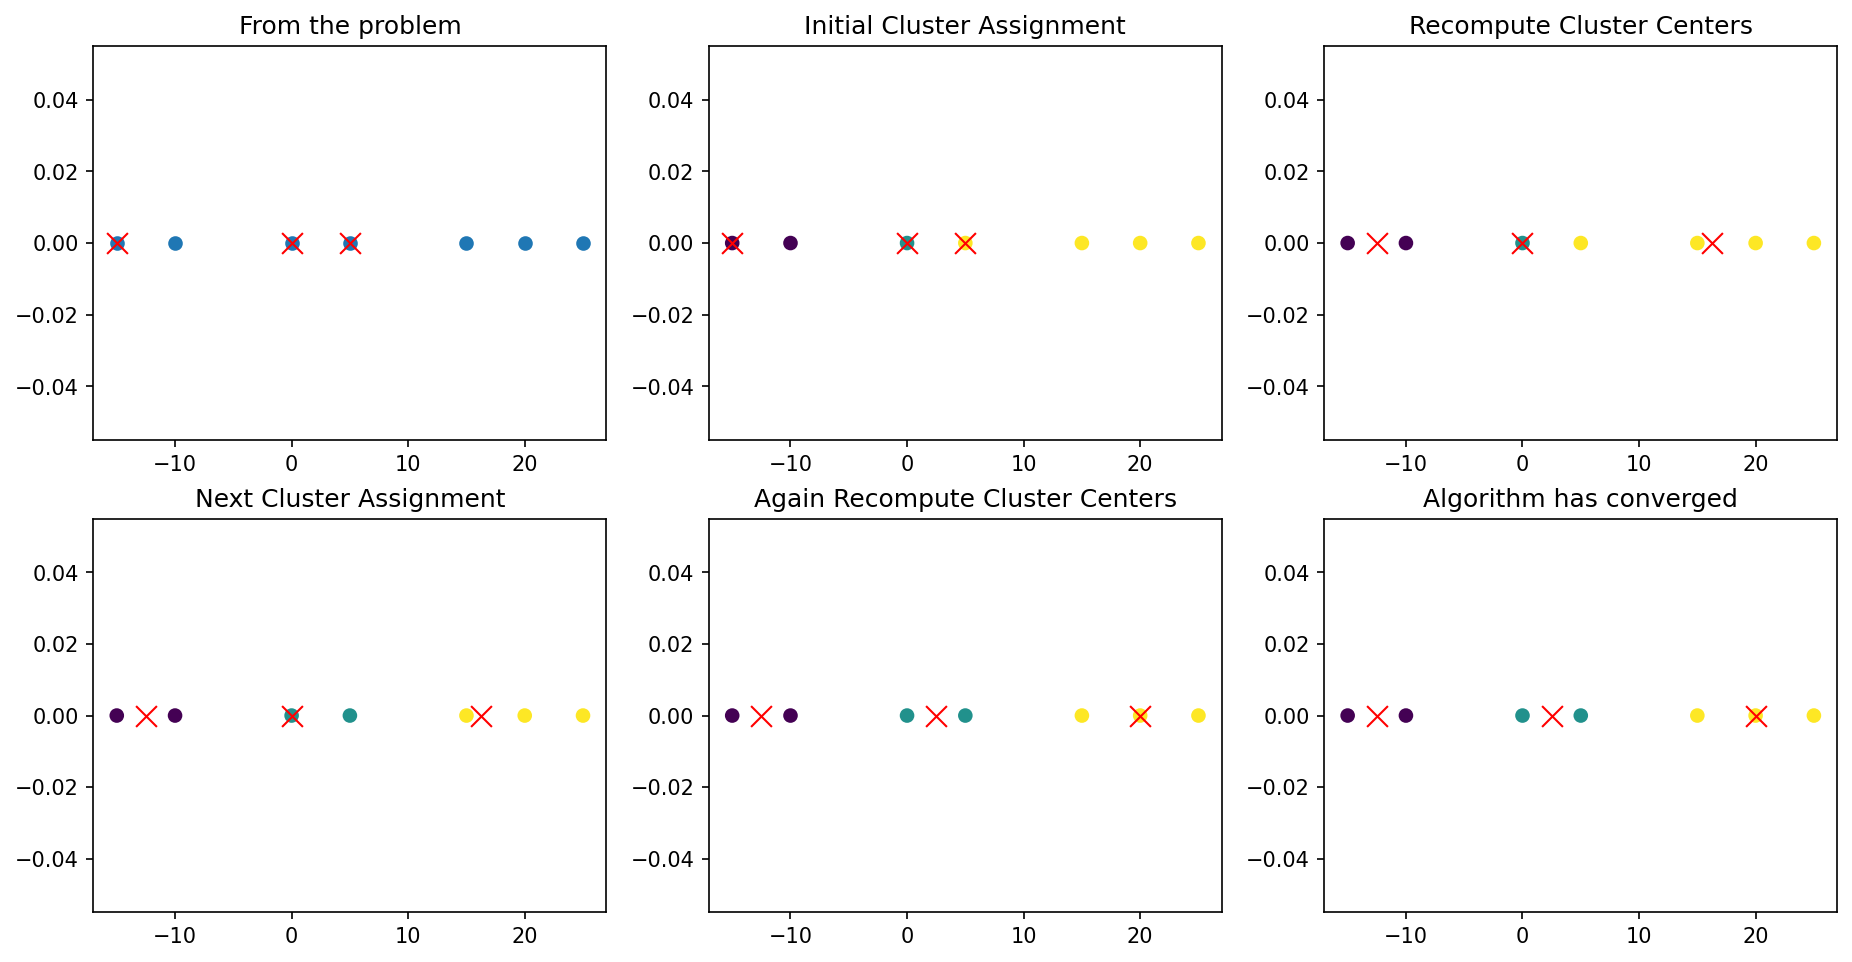

In [ ]:
plt.figure(figsize=(15, 7.5))
# From the problem
x = np.expand_dims(np.array([-15, -10, 0, 5, 15, 20, 25]), axis=1)
clusters = np.expand_dims(np.array([-15, 0, 5]), axis=1)
plt.subplot(2, 3, 1)
plt.scatter(x[:,0], np.zeros(x.shape[0]));
plt.scatter(clusters[:, 0], np.zeros(3), marker = 'x', s = 100, color = 'red', linewidth=1);
plt.title('From the problem')

# Initial Cluster Assignment
z = cluster_assignment(x, clusters)
plt.subplot(2, 3, 2)
plt.scatter(x[:,0], np.zeros(x.shape[0]), c=z);
plt.scatter(clusters[:, 0], np.zeros(3), marker = 'x', s = 100, color = 'red', linewidth=1);
plt.title('Initial Cluster Assignment')

# Recompute Cluster Centers
clusters = recompute_clusters(x, z)
plt.subplot(2, 3, 3)
plt.scatter(x[:,0], np.zeros(x.shape[0]), c=z);
plt.scatter(clusters[:, 0], np.zeros(3), marker = 'x', s = 100, color = 'red', linewidth=1);
plt.title('Recompute Cluster Centers')

# Next Cluster Assignment
z = cluster_assignment(x, clusters)
plt.subplot(2, 3, 4)
plt.scatter(x[:,0], np.zeros(x.shape[0]), c=z);
plt.scatter(clusters[:, 0], np.zeros(3), marker = 'x', s = 100, color = 'red', linewidth=1);
plt.title('Next Cluster Assignment')

# Again Recompute Cluster Centers
clusters = recompute_clusters(x, z)
plt.subplot(2, 3, 5)
plt.scatter(x[:,0], np.zeros(x.shape[0]), c=z);
plt.scatter(clusters[:, 0], np.zeros(3), marker = 'x', s = 100, color = 'red', linewidth=1);
plt.title('Again Recompute Cluster Centers')

# Cluster Assignment - No Change
# Algorithm has converged
z = cluster_assignment(x, clusters)
plt.subplot(2, 3, 6)
plt.scatter(x[:,0], np.zeros(x.shape[0]), c=z);
plt.scatter(clusters[:, 0], np.zeros(3), marker = 'x', s = 100, color = 'red', linewidth=1);
plt.title('Algorithm has converged');

## K-Means++

For the dataset below, k-means++ algorithm is run with $k=2$. Find the probability that $\mathbf{x}_2, \mathbf{x}_1$ are chosen as the initial clusters, in that order.

$$\left\{\mathbf{x_{1}} \ =\ \begin{bmatrix}
0\\
2
\end{bmatrix} ,\mathbf{\ x_{2}} \ =\ \begin{bmatrix}
2\\
0
\end{bmatrix} ,\ \mathbf{x_{3}} \ =\ \begin{bmatrix}
0\\
0
\end{bmatrix} ,\ \mathbf{x_{4}} \ =\ \begin{bmatrix}
0\\
-2
\end{bmatrix} ,\ \mathbf{x_{5}} \ =\ \begin{bmatrix}
-2\\
0
\end{bmatrix}\right\}$$

In [ ]:
dataset = np.array([[0, 2], [2, 0], [0, 0], [0, -2], [-2, 0]])
probabilities = np.array([1/len(dataset) for _ in range(len(dataset))])
print('Initial Probablities:', probabilities)
clusters = []
answer = 1

# First we select x2 = [2,0]
clusters.append(dataset[1])
answer *= probabilities[1]

# Rescore based on selected clusters
scores = np.array([min([np.linalg.norm(datapoint-cluster)**2 for cluster in clusters]) for datapoint in dataset])

# Normalize scores to probability
probabilities = scores/scores.sum()
print('Probabilities after selecting x2: ', [round(i, 3) for i in probabilities])

# Now we select x1 = [0,2]
clusters.append(dataset[0])
answer *= probabilities[0]

print('Probability of selecting [x2 x1]:', round(answer, 3))

Initial Probablities: [0.2 0.2 0.2 0.2 0.2]
Probabilities after selecting x2:  [0.222, 0.0, 0.111, 0.222, 0.444]
Probability of selecting [x2 x1]: 0.044
